In [ ]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
#sys.path.insert(0,"/content/gdrive/My Drive/Colab Notebooks/python_package/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as Func
import networkx as nx
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import scipy.sparse as sp

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device='cpu'
print(f'Loaded device: {device}')

Loaded device: cpu


# Load Data

In [ ]:
def process_features(features):
    row_sum_diag = np.sum(features, axis=1)
    row_sum_diag_inv = np.power(row_sum_diag, -1)
    row_sum_diag_inv[np.isinf(row_sum_diag_inv)] = 0.
    row_sum_inv = np.diag(row_sum_diag_inv)
    return np.dot(row_sum_inv, features)


def sample_mask(idx, l):
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

def load_data(dataset):
    ## get data
    data_path = F"/content/gdrive/MyDrive/Colab Notebooks/data"
    suffixs = ['x', 'y', 'allx', 'ally', 'tx', 'ty', 'graph']
    objects = []
    for suffix in suffixs:
        file = os.path.join(data_path, 'ind.%s.%s'%(dataset, suffix))
        objects.append(pickle.load(open(file, 'rb'), encoding='latin1'))
    x, y, allx, ally, tx, ty, graph = objects
    x, allx, tx = x.toarray(), allx.toarray(), tx.toarray()

    # test indices
    test_index_file = os.path.join(data_path, 'ind.%s.test.index'%dataset)
    with open(test_index_file, 'r') as f:
        lines = f.readlines()
    indices = [int(line.strip()) for line in lines]
    min_index, max_index = min(indices), max(indices)

    # preprocess test indices and combine all data
    tx_extend = np.zeros((max_index - min_index + 1, tx.shape[1]))
    features = np.vstack([allx, tx_extend])
    features[indices] = tx
    ty_extend = np.zeros((max_index - min_index + 1, ty.shape[1]))
    labels = np.vstack([ally, ty_extend])
    labels[indices] = ty

    # get adjacency matrix
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))
    #adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph)).toarray()
    idx_train = range(len(y))
    idx_val = range(len(y), len(y) + 500)
    idx_test = indices

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])
    zeros = np.zeros(labels.shape)
    y_train = zeros.copy()
    y_val = zeros.copy()
    y_test = zeros.copy()
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]
    features = torch.from_numpy(process_features(features))
    y_train, y_val, y_test, train_mask, val_mask, test_mask = \
        torch.from_numpy(y_train), torch.from_numpy(y_val), torch.from_numpy(y_test), \
        torch.from_numpy(train_mask), torch.from_numpy(val_mask), torch.from_numpy(test_mask)

    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask

In [ ]:
adj_ori_sparse, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data('cora')

<ipython-input-4-cd2e5733e39f>:21: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  objects.append(pickle.load(open(file, 'rb'), encoding='latin1'))
<ipython-input-4-cd2e5733e39f>:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(mask, dtype=np.bool)


# Model

In [ ]:
def preprocess_adj(A):
    '''
    Pre-process adjacency matrix
    :param A: adjacency matrix
    :return:
    '''
    I = np.eye(A.shape[0])
    A_hat = A + I # add self-loops
    D_hat_diag = np.sum(A_hat, axis=1)
    D_hat_diag_inv_sqrt = np.power(D_hat_diag, -0.5)
    D_hat_diag_inv_sqrt[np.isinf(D_hat_diag_inv_sqrt)] = 0.
    D_hat_inv_sqrt = np.diag(D_hat_diag_inv_sqrt)
    return np.dot(np.dot(D_hat_inv_sqrt, A_hat), D_hat_inv_sqrt)


class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, acti=True):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_dim, out_dim) # bias = False is also ok.
        if acti:
            self.acti = nn.ReLU(inplace=True)
        else:
            self.acti = None
    def forward(self, F):
        output = self.linear(F)
        if not self.acti:
            return output
        return self.acti(output)


class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.layer1 = GCNLayer(input_dim, hidden_dim)
        self.layer2 = GCNLayer(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)


    def forward(self, A, X):
        A = torch.from_numpy(preprocess_adj(A)).float()
        X = X.float()
        F = torch.mm(A, X)
        F = self.layer1(F)
        F = torch.mm(A, F)
        F = self.layer2(F)
        output = Func.softmax(self.fc(F), dim=1)
        return output

class Layer_GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(Layer_GCN, self).__init__()
        self.layer1 = GCNLayer(input_dim, hidden_dim)
        self.layer2 = GCNLayer(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)


    def forward(self, A, X, training_layer='fc'):
        if training_layer == 'layer1':
            A = torch.from_numpy(preprocess_adj(A)).float()
            X = X.float()
            F = torch.mm(A, X)
            F = self.layer1(F)

        elif training_layer == 'layer2':
            A = torch.from_numpy(preprocess_adj(A)).float()
            X = X.float()
            F = torch.mm(A, X)
            F = self.layer1(F)
            F = torch.mm(A, F)
            F = self.layer2(F)
        elif training_layer == 'fc':
            A = torch.from_numpy(preprocess_adj(A)).float()
            X = X.float()
            F = torch.mm(A, X)
            F = self.layer1(F)
            F = torch.mm(A, F)
            F = self.layer2(F)
            F = Func.softmax(self.fc(F), dim=1)
        return F

# Evaluation

In [ ]:
def get_accuracy(outputs, labels, mask):

    outputs = torch.argmax(outputs, dim=1)
    labels = torch.argmax(labels, dim=1)
    outputs = outputs.numpy()
    labels = labels.numpy()
    correct = outputs == labels
    #print(correct)
    mask = mask.float().numpy()
    tp = np.sum(correct * mask)
    return tp / np.sum(mask)

def plot_loss(layer1, epoche, loss_type):
    """
    plot the loss change during the training precedure
    """
    plt.title("Train "+ loss_type)
    plt.xlabel("epoch")
    plt.ylabel(loss_type)
    epoche_range=[i+1 for i in range(epoche)]
    plt.plot(epoche_range, layer1)
    #plt.plot(epoche_range, layer2)
    #plt.plot(epoche_range, fc)
    plt.legend([loss_type], loc='best')
    plt.show()

def plot_acc(train, test, epoche):
    """
    plot the loss change during the training precedure
    """
    plt.title("Train and validation Accuarcy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    epoche_range=[i+1 for i in range(epoche)]
    plt.plot(epoche_range, train)
    plt.plot(epoche_range, test)
    #plt.plot(epoche_range, fc)
    plt.legend(['train accuracy', 'valid accuracy'], loc='best')
    plt.show()

def plot_both_loss(train, test, epoche):
    """
    plot the loss change during the training precedure
    """
    plt.title("Train and validation loss")
    plt.xlabel("epoch")
    plt.ylabel("cross entropy")
    epoche_range=[i+1 for i in range(epoche)]
    plt.plot(epoche_range, train)
    plt.plot(epoche_range, test)
    #plt.plot(epoche_range, fc)
    plt.legend(['train loss', 'valid loss'], loc='best')
    plt.show()

class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.loss = nn.CrossEntropyLoss(reduction='none')
    def forward(self, output, labels, mask):
        labels = torch.argmax(labels, dim=1)
        loss = self.loss(output, labels)
        mask = mask.float()
        mask /= torch.mean(mask)
        loss *= mask
        return torch.mean(loss)

def get_loss(output, labels, mask):
    loss = Loss()
    return loss(output, labels, mask)

# BP

In [ ]:
model = GCN(features.shape[1], 16, y_train.shape[1])

In [ ]:
model_save_name = 'BPgraphnode.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
model = torch.load(path)
outputs = model(adj_ori_sparse.toarray(), features)
get_accuracy(outputs, y_train, train_mask),  get_accuracy(outputs, y_val, val_mask)

(0.99285716, 0.706)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
loss_func = nn.CrossEntropyLoss(reduction='none')
num_epochs = 200

Epoch: 1, train loss: 1.946082, val loss: 1.946656, train ac: 0.142857, val ac: 0.058000
Epoch: 2, train loss: 1.945960, val loss: 1.945580, train ac: 0.142857, val ac: 0.162000
Epoch: 3, train loss: 1.945822, val loss: 1.944872, train ac: 0.142857, val ac: 0.162000
Epoch: 4, train loss: 1.945653, val loss: 1.944607, train ac: 0.142857, val ac: 0.162000
Epoch: 5, train loss: 1.945442, val loss: 1.944535, train ac: 0.142857, val ac: 0.156000
Epoch: 6, train loss: 1.945187, val loss: 1.944543, train ac: 0.142857, val ac: 0.156000
Epoch: 7, train loss: 1.944862, val loss: 1.944584, train ac: 0.142857, val ac: 0.158000
Epoch: 8, train loss: 1.944465, val loss: 1.944641, train ac: 0.142857, val ac: 0.158000
Epoch: 9, train loss: 1.943983, val loss: 1.944704, train ac: 0.328571, val ac: 0.250000
Epoch: 10, train loss: 1.943403, val loss: 1.944758, train ac: 0.214286, val ac: 0.128000
Epoch: 11, train loss: 1.942706, val loss: 1.944774, train ac: 0.185714, val ac: 0.126000
Epoch: 12, train lo

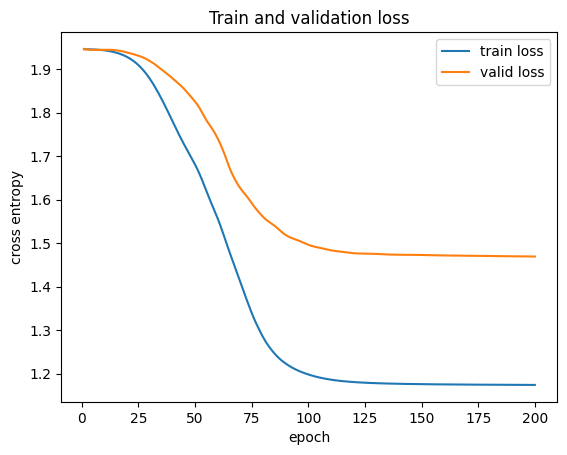

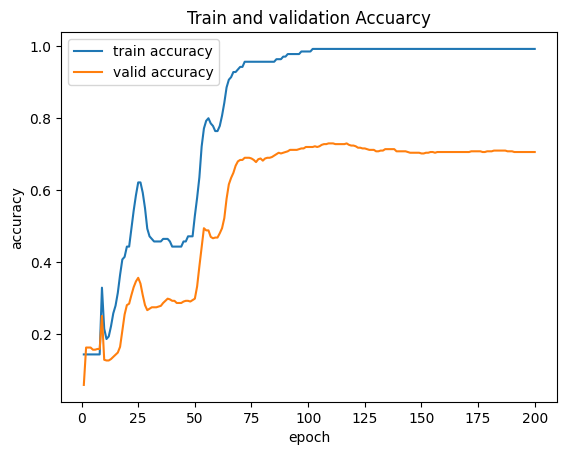

In [ ]:
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
best = 1e9
count = 0
for epoch in range(num_epochs):

    outputs = model(adj_ori_sparse.toarray(), features)
    loss = get_loss(outputs, y_train, train_mask)
    val_loss = get_loss(outputs, y_val, val_mask).detach().numpy()
    train_accuracy = get_accuracy(outputs, y_train, train_mask)
    val_accuracy = get_accuracy(outputs, y_val, val_mask)

    model.train()
    print("Epoch: %d, train loss: %f, val loss: %f, train ac: %f, val ac: %f"
                  %(epoch+1, loss.detach().numpy(), val_loss, train_accuracy, val_accuracy))
    #if epoch % args.checkpoint_interval == 0:
            #torch.save(model.state_dict(), os.path.join(saved_checkpoint_dir, "gcn_%d.pth"%epoch))
    if loss.item() < best:
        best = loss.item()
        count = count + 1
        model_save_name = 'BPgraphnode.pt'
        path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
        torch.save(model, path)
    if train_accuracy == 1:
        break
    train_loss_list.append(loss.item())
    val_loss_list.append(val_loss)
    train_acc_list.append(train_accuracy)
    val_acc_list.append(val_accuracy)
    optimizer.zero_grad()  # Important
    loss.backward()
    optimizer.step()

print(count)
plot_both_loss(train_loss_list, val_loss_list, num_epochs)
plot_acc(train_acc_list, val_acc_list, num_epochs)


# Mine

In [ ]:
import math

torch.autograd.set_detect_anomaly(True)

EPS = 1e-6

class EMALoss(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, running_ema):
        ctx.save_for_backward(input, running_ema)
        input_log_sum_exp = input.exp().mean().log()

        return input_log_sum_exp

    @staticmethod
    def backward(ctx, grad_output):
        input, running_mean = ctx.saved_tensors
        grad = grad_output * input.exp().detach() / \
            (running_mean + EPS) / input.shape[0]
        return grad, None


def ema(mu, alpha, past_ema):
    return alpha * mu + (1.0 - alpha) * past_ema


def ema_loss(x, running_mean, alpha):
    t_exp = torch.exp(torch.logsumexp(x, 0) - math.log(x.shape[0])).detach()
    if running_mean == 0:
        running_mean = t_exp
    else:
        running_mean = ema(t_exp, alpha, running_mean.item())
    t_log = EMALoss.apply(x, running_mean)

    # Recalculate ema

    return t_log, running_mean

class ConcatLayer(nn.Module):
    def __init__(self, dim=1):
        super().__init__()
        self.dim = dim

    def forward(self, x, y):
        x = x.view(x.shape[0], -1)
        y = y.view(y.shape[0], -1)
        return torch.cat((x, y), self.dim)


class CustomSequential(nn.Sequential):
    def forward(self, *input):
        for module in self._modules.values():
            if isinstance(input, tuple):
                input = module(*input)
            else:
                input = module(input)
        return input

class T(nn.Module):
    def __init__(self, x_dim, z_dim):
        super().__init__()
        self.layers = CustomSequential(ConcatLayer(), nn.Linear(x_dim + z_dim, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 1))

    def forward(self, x, z):
        return self.layers(x, z)

class Mine(nn.Module):
    def __init__(self, T, loss='mine', alpha=0.01, method=None):
        super().__init__()
        self.running_mean = 0
        self.loss = loss
        self.alpha = alpha
        self.method = method

        if method == 'concat':
            if isinstance(T, nn.Sequential):
                self.T = CustomSequential(ConcatLayer(), *T)
            else:
                self.T = CustomSequential(ConcatLayer(), T)
        else:
            self.T = T

    def forward(self, x, z, z_marg=None):
        if z_marg is None:
            z_marg = z[torch.randperm(x.shape[0])]
        #print(x.shape, z.shape, z_marg.shape)
        t = self.T(x, z).mean()
        t_marg = self.T(x, z_marg)

        if self.loss in ['mine']:
            second_term, self.running_mean = ema_loss(
                t_marg, self.running_mean, self.alpha)
        elif self.loss in ['fdiv']:
            second_term = torch.exp(t_marg - 1).mean()
        elif self.loss in ['mine_biased']:
            second_term = torch.logsumexp(
                t_marg, 0) - math.log(t_marg.shape[0])

        return -t + second_term

# GMI

In [ ]:
def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def negative_sampling(adj_ori, sample_times, emb_dim):
    sample_list = []
    for j in range(sample_times):
        sample_iter = []
        i = 0
        while True:
            #randnum = np.random.randint(0,adj_ori.shape[0])
            randnum = np.random.randint(0, emb_dim)
            if randnum!=i:
                sample_iter.append(randnum)
                i = i+1
            if len(sample_iter)==adj_ori.shape[0]:
                break
        sample_list.append(sample_iter)
    return sample_list

def mi_loss_jsd(pos, neg):
    e_pos = torch.mean(sp_func(-pos))
    e_neg = torch.mean(torch.mean(sp_func(neg),0))
    return e_pos+e_neg

def reconstruct_loss(pre, gnd):
    nodes_n = gnd.shape[0]
    edges_n = np.sum(gnd)/2
    weight1 = (nodes_n*nodes_n-edges_n)*1.0/edges_n
    weight2 = nodes_n*nodes_n*1.0/(nodes_n*nodes_n-edges_n)
    gnd = torch.FloatTensor(gnd).to(device)
    temp1 = gnd*torch.log(pre+(1e-10))*(-weight1)
    temp2 = (1-gnd)*torch.log(1-pre+(1e-10))
    return torch.mean(temp1-temp2)*weight2

def sp_func(arg):
    return torch.log(1+torch.exp(arg))

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_h1, n_h2):
        super(Discriminator, self).__init__()
        self.f_k = nn.Bilinear(n_h1, n_h2, 1)
        self.act = nn.Sigmoid()

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, h_c, h_pl, sample_list, s_bias1=None, s_bias2=None):
        #print(h_c.shape, h_pl.shape)  #1: h_c output 16 h_pl input 1433  2: h_c h_neighbor 1433  h_pl output 16
        sc_1 = self.f_k(h_pl.float(), h_c.float())
        if sc_1.dim == 3:
            sc_1 = torch.squeeze(self.f_k(h_pl.float(), h_c.float()), 2)
        sc_1 = self.act(sc_1)
        sc_2_list = []
        #print(len(h_pl[0]), np.max(sample_list[0]))
        for i in range(len(sample_list)):
            h_mi = h_pl[0][sample_list[i]]
            h_mi = torch.unsqueeze(h_mi, 0)
            h_mi = torch.transpose(h_mi, 0, 1).expand_as(h_pl)
            sc_2_iter = self.f_k(h_mi.float(), h_c.float())
            if sc_2_iter.dim == 3:
                sc_2_iter = torch.squeeze(sc_2_iter, 2)
            sc_2_list.append(sc_2_iter)
        sc_2_stack = torch.squeeze(torch.stack(sc_2_list,1),0)
        sc_2 = self.act(sc_2_stack)
        sc_1 = sc_1.detach()
        sc_2 = sc_2.detach()

        if s_bias1 is not None:
            sc_1 += s_bias1
        if s_bias2 is not None:
            sc_2 += s_bias2

        return sc_1, sc_2

class AvgNeighbor(nn.Module):
    def __init__(self):
        super(AvgNeighbor, self).__init__()

    def forward(self, seq, adj_ori):

        adj_ori = sparse_mx_to_torch_sparse_tensor(adj_ori)
        if torch.cuda.is_available():
            adj_ori = adj_ori.to(device)

        #return torch.unsqueeze(torch.spmm(adj_ori.float(), torch.squeeze(seq, 0).float()), 0)
        return torch.spmm(adj_ori.float(), torch.squeeze(seq, 0).float())

In [ ]:
class GMI(nn.Module):
    def __init__(self, n_in, n_h, activation):   # n_in 1433 n_h 15
        super(GMI, self).__init__()
        #self.gcn1 = GCN(n_in, n_h, activation)  # if on citeseer and pubmed, the encoder is 1-layer GCN, you need to modify it
        #self.gcn2 = GCN(n_h, n_h, activation)
        self.disc1 = Discriminator(n_in, n_h)
        self.disc2 = Discriminator(n_h, n_in)
        self.avg_neighbor = AvgNeighbor()
        self.prelu = nn.PReLU()
        self.sigm = nn.Sigmoid()

    def forward(self, input_feature, output_feature, adj_ori, neg_num, adj, adj_target, samp_bias1, samp_bias2, alpha=0.8, beta=1.0, gamma=1.0):
        #h_1, h_w = self.gcn1(seq1, adj)
        #h_2, _ = self.gcn2(h_1, adj)

        h_neighbor = self.prelu(self.avg_neighbor(input_feature, adj_ori))  #[2708, 1433]

        """FMI (X_i consists of the node i itself and its neighbors)"""
        # I(h_i; x_i)
        res_mi_pos, res_mi_neg = self.disc1(output_feature, input_feature, negative_sampling(adj_ori, neg_num, input_feature.shape[1]), samp_bias1, samp_bias2)
        # I(h_i; x_j) node j is a neighbor
        res_local_pos, res_local_neg = self.disc2(h_neighbor, output_feature, negative_sampling(adj_ori, neg_num, output_feature.shape[1]), samp_bias1, samp_bias2)
        """I(w_ij; a_ij)"""
        adj_rebuilt = self.sigm(torch.mm(torch.squeeze(output_feature), torch.t(torch.squeeze(output_feature))))
        res = (res_mi_pos, res_mi_neg, res_local_pos, res_local_neg, adj_rebuilt)

        return alpha*mi_loss_jsd(res[0], res[1]) + beta*mi_loss_jsd(res[2], res[3]) + gamma*reconstruct_loss(res[4], adj_target)
        #return res_mi_pos, res_mi_neg, res_local_pos, res_local_neg, adj_rebuilt
    # detach the return variables
    def embed(self, seq, adj):
        h_1, _ = self.gcn1(seq, adj)
        h_2, _ = self.gcn2(h_1, adj)

        return h_2.detach()


# Model and Estimator Initialization

In [ ]:
model = Layer_GCN(features.shape[1], 16, y_train.shape[1]).to(device)
T_estimator = [GMI(features.shape[1], 16, 'prelu'),
               Mine(T(y_train.shape[1], 16))]

In [ ]:
# save model
model_save_name = 'GnodeGMI.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
torch.save(model, path)
model_save_name = 'GnodeGMIlayer1.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
torch.save(T_estimator[0], path)
model_save_name = 'GnodeGMIlayer2.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
torch.save(T_estimator[1], path)


# Training layer1

In [ ]:
def training_layer1(model, mine, loss_list, layer_list, num_epochs, input_features, sparse_adj):
    for param in model.parameters():
        param.requires_grad = False


    #training mp1
    print("Training mp1")
    for name, param in model.layer1.named_parameters():
        param.requires_grad = True

    mine = T_estimator[0].to(device)


    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-8},
                                {"params": mine.parameters(), "lr": 1e-8}])
    loss_type = loss_list[0]
    training_layer = layer_list[0]
    input_matrix = sparse_adj.toarray()   # input dense matrix
    input_features = features

    adj_ori = sparse_adj
    adj = normalize_adj(adj_ori + sp.eye(adj_ori.shape[0]))
    sp_adj = sparse_mx_to_torch_sparse_tensor(adj) #tensor


    adj_dense = adj_ori.toarray()
    adj_target = adj_dense+np.eye(adj_dense.shape[0])
    adj_row_avg = 1.0/np.sum(adj_dense, axis=1)
    adj_row_avg[np.isnan(adj_row_avg)] = 0.0
    adj_row_avg[np.isinf(adj_row_avg)] = 0.0
    adj_dense = adj_dense*1.0
    for i in range(adj_ori.shape[0]):
        adj_dense[i] = adj_dense[i]*adj_row_avg[i]
    adj_ori_ = sp.csr_matrix(adj_dense, dtype=np.float32)

    layer1_loss = []
    #best = 1e9
    best = 3.6710658073425293

    count = 0
    model.train()
    mine.train()
    for epoch in range(num_epochs):
    #Forward

        output_features = model(input_matrix, input_features, training_layer)
        loss = mine(input_feature=input_features, output_feature=output_features, adj_ori=adj_ori, neg_num=5, adj=sp_adj, adj_target=adj_target, samp_bias1=None, samp_bias2=None)
        if loss.item() < best:
            model_save_name = 'GnodeGMI.pt'
            path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
            torch.save(model, path)
            model_save_name = 'GnodeGMIlayer1.pt'
            path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
            torch.save(mine, path)
            best = loss.item()
            count = count + 1

        print('Epoch:', (epoch+1), '  Loss:', loss.item())
        layer1_loss.append(loss.item())
        optimizer.zero_grad()  # Important
        loss.backward()
        optimizer.step()

    for name, param in model.layer1.named_parameters():
        param.requires_grad = False

    print(count)
    print(best)
    return layer1_loss

In [ ]:
model_save_name = 'GnodeGMI.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
model = torch.load(path)
model_save_name = 'GnodeGMIlayer1.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
T_estimator1 = torch.load(path)
model_save_name = 'GnodeGMIlayer2.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
T_estimator2 = torch.load(path)
T_estimator = [T_estimator1, T_estimator2]

Training mp1
Epoch: 1   Loss: 3.671123504638672
Epoch: 2   Loss: 3.6711153984069824
Epoch: 3   Loss: 3.671113967895508
Epoch: 4   Loss: 3.6711606979370117
Epoch: 5   Loss: 3.6711244583129883
Epoch: 6   Loss: 3.6711416244506836
Epoch: 7   Loss: 3.6711196899414062
Epoch: 8   Loss: 3.671100616455078
Epoch: 9   Loss: 3.671116828918457
Epoch: 10   Loss: 3.6711344718933105
Epoch: 11   Loss: 3.67112398147583
Epoch: 12   Loss: 3.671109199523926
Epoch: 13   Loss: 3.6711254119873047
Epoch: 14   Loss: 3.6711373329162598
Epoch: 15   Loss: 3.6711177825927734
Epoch: 16   Loss: 3.6711106300354004
Epoch: 17   Loss: 3.671135902404785
Epoch: 18   Loss: 3.671161651611328
Epoch: 19   Loss: 3.6711387634277344
Epoch: 20   Loss: 3.6711301803588867
Epoch: 21   Loss: 3.6711435317993164
Epoch: 22   Loss: 3.67111873626709
Epoch: 23   Loss: 3.6711254119873047
Epoch: 24   Loss: 3.6711349487304688
Epoch: 25   Loss: 3.671111583709717
Epoch: 26   Loss: 3.6711249351501465
Epoch: 27   Loss: 3.6711535453796387
Epoch: 28

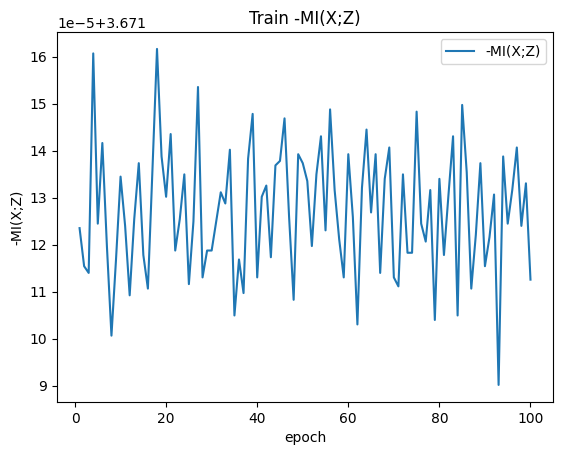

In [ ]:
loss_list = ['-MI(X;Z)', "-MI(Y;Z)", "cross entropy"]
layer_list = ['layer1', 'layer2', 'fc']
num_epochs = 100
layer1_loss = training_layer1(model, T_estimator, loss_list, layer_list, num_epochs, features, adj_ori_sparse)
plot_loss(layer1_loss, num_epochs, loss_list[0])

lowest loss: 3.6210217475891113


# Training layer2

In [ ]:
def training_layer2(model, mine, loss_list, layer_list, num_epochs, input_features, sparse_adj):
    for param in model.parameters():
        param.requires_grad = False

    #training mp2
    print("Training mp2")
    for name, param in model.layer2.named_parameters():
        param.requires_grad = True

    mine = T_estimator[1].to(device)
    model.to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-8},
                                {"params": mine.parameters(), "lr": 1e-8}])
    loss_type = loss_list[1]
    training_layer = layer_list[1]

    input_features = features

    layer2_loss = []

    #best = 1e9
    best = -1.8557629585266113

    count = 0
    model.train()
    mine.train()
    for epoch in range(num_epochs):
        #Forward
        output_features = model(sparse_adj.toarray(), input_features, training_layer)
        train_output_features = output_features[train_mask].float()
        train_label = y_train[train_mask].float()
        loss = mine(train_label, train_output_features)
        if loss.item() < best:
            model_save_name = 'GnodeGMI.pt'
            path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
            torch.save(model, path)
            model_save_name = 'GnodeGMIlayer2.pt'
            path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
            torch.save(mine, path)
            count = count + 1
            best = loss.item()
        print('Epoch:', (epoch+1),'/', num_epochs, '  Loss:', loss.item())
        layer2_loss.append(loss.item())
        optimizer.zero_grad()  # Important
        loss.backward()
        optimizer.step()

    for name, param in model.layer2.named_parameters():
        param.requires_grad = False
    print(count)
    print(best)
    return layer2_loss

In [ ]:
model_save_name = 'GnodeGMI.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
model = torch.load(path)
model_save_name = 'GnodeGMIlayer1.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
T_estimator1 = torch.load(path)
model_save_name = 'GnodeGMIlayer2.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
T_estimator2 = torch.load(path)
T_estimator = [T_estimator1, T_estimator2]

Training mp2
Epoch: 1 / 100   Loss: -1.2845741510391235
Epoch: 2 / 100   Loss: -1.1853539943695068
Epoch: 3 / 100   Loss: -1.0227711200714111
Epoch: 4 / 100   Loss: -1.1452597379684448
Epoch: 5 / 100   Loss: -1.1760486364364624
Epoch: 6 / 100   Loss: -1.2677432298660278
Epoch: 7 / 100   Loss: -1.1393901109695435
Epoch: 8 / 100   Loss: -1.2208870649337769
Epoch: 9 / 100   Loss: -1.0964939594268799
Epoch: 10 / 100   Loss: -1.1343767642974854
Epoch: 11 / 100   Loss: -1.1858547925949097
Epoch: 12 / 100   Loss: -1.141215205192566
Epoch: 13 / 100   Loss: -1.358014464378357
Epoch: 14 / 100   Loss: -1.2965693473815918
Epoch: 15 / 100   Loss: -1.0256505012512207
Epoch: 16 / 100   Loss: -1.3281607627868652
Epoch: 17 / 100   Loss: -1.3364696502685547
Epoch: 18 / 100   Loss: -1.139746069908142
Epoch: 19 / 100   Loss: -1.312854528427124
Epoch: 20 / 100   Loss: -1.1361595392227173
Epoch: 21 / 100   Loss: -1.323784589767456
Epoch: 22 / 100   Loss: -1.3086069822311401
Epoch: 23 / 100   Loss: -1.288697

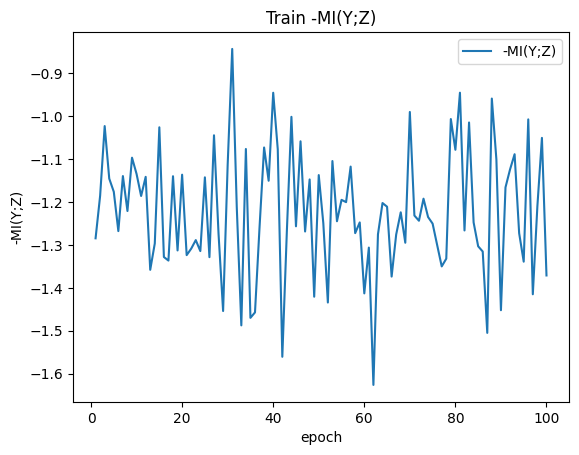

In [ ]:
loss_list = ['-MI(X;Z)', "-MI(Y;Z)", "cross entropy"]
layer_list = ['layer1', 'layer2', 'fc']
num_epochs = 100
layer2_loss = training_layer2(model, T_estimator, loss_list, layer_list, num_epochs, features, adj_ori_sparse)
plot_loss(layer2_loss, num_epochs, loss_list[1])

lowest loss: -1.530648946762085

# Training fc

In [ ]:
def training_fc(model, mine, loss_list, layer_list, num_epochs, input_features, sparse_adj):
    for param in model.parameters():
        param.requires_grad = False

    #training fc
    print("Training fc")
    for name, param in model.fc.named_parameters():
        param.requires_grad = True
    model.to(device)
    mine = nn.CrossEntropyLoss(reduction='none').to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

    loss_type = loss_list[2]
    training_layer = layer_list[2]

    input_features = features

    #best = 1e9
    best = 1.3530611991882324
    count = 0
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    model.train()

    for epoch in range(num_epochs):
        #Forward
        outputs = model(sparse_adj.toarray(), input_features, training_layer)
        loss = get_loss(outputs, y_train, train_mask)
        val_loss = get_loss(outputs, y_val, val_mask).detach().numpy()
        train_accuracy = get_accuracy(outputs, y_train, train_mask)
        val_accuracy = get_accuracy(outputs, y_val, val_mask)
        print("Epoch: %d/%d, train loss: %f, val loss: %f, train ac: %f, val ac: %f"
                  %(epoch+1, num_epochs, loss.detach().numpy(), val_loss, train_accuracy, val_accuracy))
        train_loss_list.append(loss.item())
        val_loss_list.append(val_loss)
        train_acc_list.append(train_accuracy)
        val_acc_list.append(val_accuracy)
        if loss.item() < best:
            model_save_name = 'GnodeGMI.pt'
            path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
            torch.save(model, path)

            best = loss.item()
            count = count + 1
        #print('Epoch:', (epoch+1), '  Loss:', loss.item())

        optimizer.zero_grad()  # Important
        loss.backward()
        optimizer.step()

    for name, param in model.fc.named_parameters():
        param.requires_grad = False
    print(count)
    print(best)
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list

In [ ]:
model_save_name = 'GnodeGMI.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
model = torch.load(path)
model_save_name = 'GnodeGMIlayer1.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
T_estimator1 = torch.load(path)
model_save_name = 'GnodeGMIlayer2.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
T_estimator2 = torch.load(path)
T_estimator = [T_estimator1, T_estimator2]
outputs = model(adj_ori_sparse.toarray(), features)
get_accuracy(outputs, y_train, train_mask),  get_accuracy(outputs, y_val, val_mask)

RuntimeError: ignored

Training fc
Epoch: 1/100, train loss: 1.353012, val loss: 1.488396, train ac: 0.828571, val ac: 0.688000
Epoch: 2/100, train loss: 1.352959, val loss: 1.488383, train ac: 0.828571, val ac: 0.688000
Epoch: 3/100, train loss: 1.352907, val loss: 1.488421, train ac: 0.828571, val ac: 0.688000
Epoch: 4/100, train loss: 1.352855, val loss: 1.488356, train ac: 0.828571, val ac: 0.688000
Epoch: 5/100, train loss: 1.352803, val loss: 1.488366, train ac: 0.828571, val ac: 0.688000
Epoch: 6/100, train loss: 1.352751, val loss: 1.488404, train ac: 0.828571, val ac: 0.688000
Epoch: 7/100, train loss: 1.352699, val loss: 1.488428, train ac: 0.828571, val ac: 0.688000
Epoch: 8/100, train loss: 1.352647, val loss: 1.488420, train ac: 0.828571, val ac: 0.688000
Epoch: 9/100, train loss: 1.352596, val loss: 1.488397, train ac: 0.828571, val ac: 0.688000
Epoch: 10/100, train loss: 1.352544, val loss: 1.488381, train ac: 0.828571, val ac: 0.688000
Epoch: 11/100, train loss: 1.352493, val loss: 1.488377, 

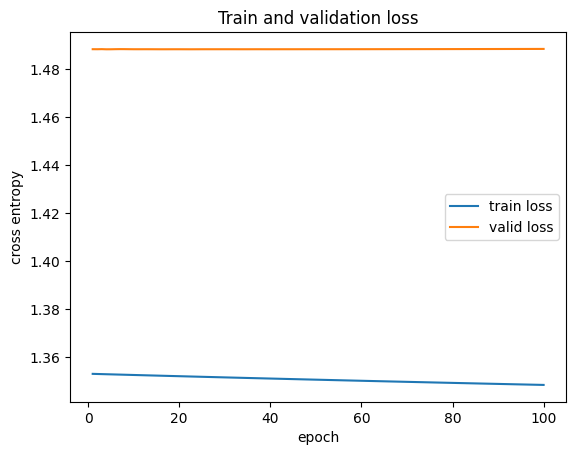

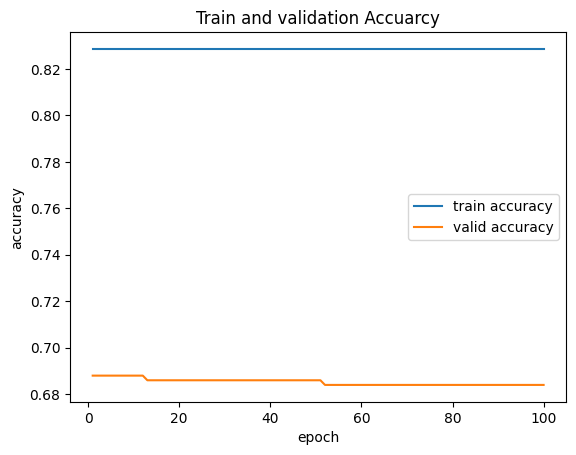

In [ ]:
loss_list = ['-MI(X;Z)', "-MI(Y;Z)", "cross entropy"]
layer_list = ['layer1', 'layer2', 'fc']
num_epochs = 100
train_loss_list, val_loss_list, train_acc_list, val_acc_list = training_fc(model, T_estimator, loss_list, layer_list, num_epochs, features, adj_ori_sparse)
plot_both_loss(train_loss_list, val_loss_list, num_epochs)
plot_acc(train_acc_list, val_acc_list, num_epochs)

lowest loss:

1.368255615234375

Training fc
Epoch: 1/100, train loss: 1.365312, val loss: 1.488571, train ac: 0.814286, val ac: 0.692000

In [ ]:
model_save_name = 'GnodeGMI.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
model = torch.load(path)
outputs = model(adj_ori_sparse.toarray(), features)
get_accuracy(outputs, y_train, train_mask),  get_accuracy(outputs, y_val, val_mask)

(0.82857144, 0.684)

In [ ]:
model

Layer_GCN(
  (layer1): GCNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=True)
    (acti): ReLU(inplace=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
    (acti): ReLU(inplace=True)
  )
  (fc): Linear(in_features=16, out_features=7, bias=True)
)

In [ ]:
features.shape, y_train.shape, y_val.shape, y_test.shape

(torch.Size([2708, 1433]),
 torch.Size([2708, 7]),
 torch.Size([2708, 7]),
 torch.Size([2708, 7]))

In [ ]:
val_features = features[val_mask]
val_label = torch.argmax(y_val[val_mask], dim = 1)

In [ ]:
x = np.array(val_features)
y = np.array(val_label)

In [ ]:
y.sum()

0

In [ ]:
x.shape, y.shape

((500, 1433), (500,))

In [ ]:
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd
import numpy as np
from google.colab import files

In [ ]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.060069
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.138298
[t-SNE] KL divergence after 1000 iterations: 1.677401


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

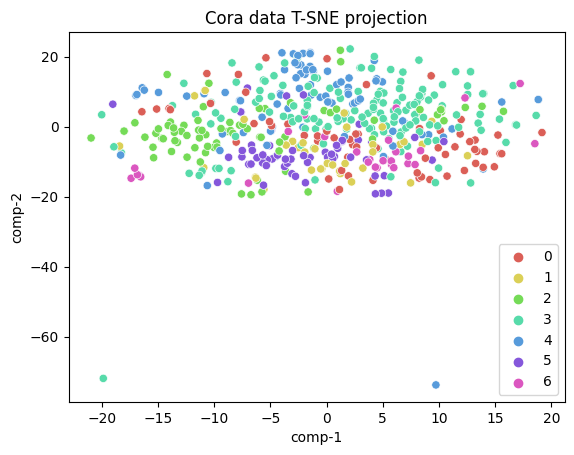

In [ ]:
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 7),
                data=df).set(title="Cora data T-SNE projection")

plt.savefig('GNN_Cora_tsne.pdf')
files.download('GNN_Cora_tsne.pdf')

In [ ]:
gcn1_outputs = model(adj_ori_sparse.toarray(), features, 'layer1')[val_mask]

In [ ]:
gcn1_x = np.array(gcn1_outputs)

In [ ]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(gcn1_x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.255087
[t-SNE] KL divergence after 250 iterations with early exaggeration: 40.616867
[t-SNE] KL divergence after 1000 iterations: 0.124066


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

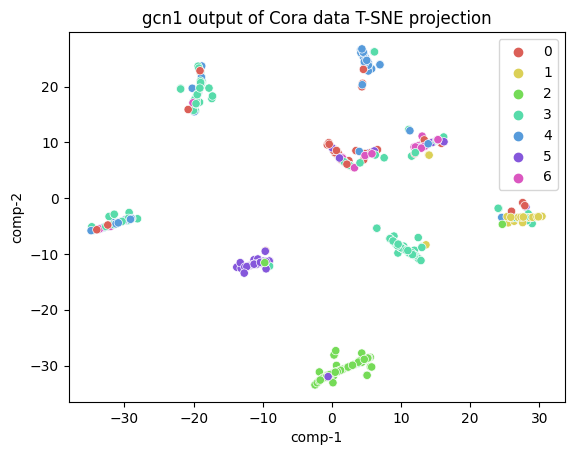

In [ ]:
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 7),
                data=df).set(title="gcn1 output of Cora data T-SNE projection")

plt.savefig('GNN_Cora_layer1_tsne.pdf')
files.download('GNN_Cora_layer1_tsne.pdf')

In [ ]:
gcn2_outputs = model(adj_ori_sparse.toarray(), features, 'layer2')[val_mask]
gcn2_x = np.array(gcn2_outputs)

In [ ]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(gcn2_x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.091801
[t-SNE] KL divergence after 250 iterations with early exaggeration: 40.551350
[t-SNE] KL divergence after 1000 iterations: 0.129967


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

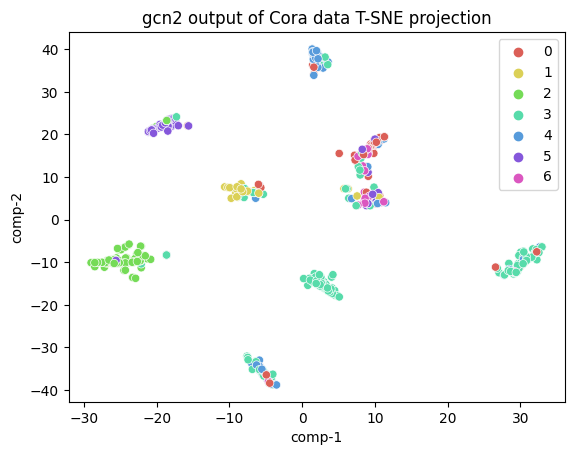

In [ ]:
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 7),
                data=df).set(title="gcn2 output of Cora data T-SNE projection")

plt.savefig('GNN_Cora_layer2_tsne.pdf')
files.download('GNN_Cora_layer2_tsne.pdf')

In [ ]:
plt.savefig('GNN_Cora_layer2_tsne.pdf')

<Figure size 640x480 with 0 Axes>

In [ ]:
fc_outputs = model(adj_ori_sparse.toarray(), features, 'fc')[val_mask]
fc_x = fc_outputs.detach().numpy()

In [ ]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(fc_x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.000007
[t-SNE] KL divergence after 250 iterations with early exaggeration: 40.623425
[t-SNE] KL divergence after 1000 iterations: 0.083253


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

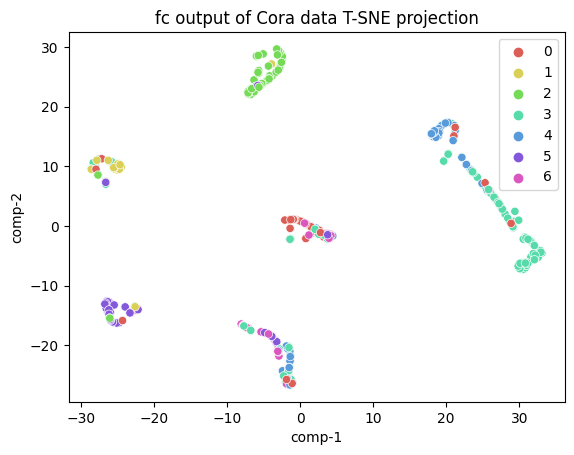

In [ ]:
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 7),
                data=df).set(title="fc output of Cora data T-SNE projection")

plt.savefig('GNN_Cora_fc_tsne.pdf')
files.download('GNN_Cora_fc_tsne.pdf')

In [ ]:
plt.savefig('GNN_Cora_fc_tsne.pdf')

<Figure size 640x480 with 0 Axes>